In [1]:
import os

from descartes.patch import PolygonPatch
import joblib
import geopandas as gpd
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
d6_bbls = np.load("data/bimg_labels_d6.npy")
d9_bbls = np.load("data/bimg_labels_d9.npy")
pluto = gpd.read_file("data/pluto/MNMapPLUTO.shp")
pluto["surface_area"] = pluto["NumFloors"] * pluto.geometry.length
in_frame = pluto[(pluto.BBL.isin(np.unique(d6_bbls.ravel()))) | pluto.BBL.isin(np.unique(d9_bbls.ravel()))]
out_frame = pluto[(pluto.geometry.centroid.y < 215000) & ~pluto.index.isin(in_frame.index)]

final_light_d6 = pd.read_csv("data/bbl_2017-09-28/2017-09-28_d6_10m.csv")
final_light_d9 = pd.read_csv("data/bbl_2017-09-28/2017-09-28_d9_10m.csv")
for df in (final_light_d6, final_light_d9):
    del df["Unnamed: 0"]
    del df["lat"]
    del df["lng"]
final_light_d6 = final_light_d6.set_index("BBL").swapaxes(1, 0)
final_light_d9 = final_light_d9.set_index("BBL").swapaxes(1, 0)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-df8aa5700505>", line 6, in <module>
    out_frame = pluto[(pluto.geometry.centroid.y < 215000) & ~pluto.index.isin(in_frame.index)]
  File "/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/geopandas/base.py", line 172, in centroid
    return _geo_unary_op(self, 'centroid')
  File "/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/geopandas/base.py", line 60, in _geo_unary_op
    return gpd.GeoSeries([getattr(geom, op) for geom in this.geometry],
  File "/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/geopandas/base.py", line 60, in <listcomp>
    return gpd.GeoSeries([getattr(geom, op) for geom in this.geometry],
  File "/home/cusp/clm633/.conda/envs/pyart/lib/python3.6/site-packages/shapely/geometry/b

KeyboardInterrupt: 

In [53]:
concatd = pd.concat((final_light_d6, final_light_d9))
final_light = concatd.groupby(concatd.index).mean()


In [7]:
if os.path.exists("data/impute_dists_centroid.gz"):
    dists = joblib.load("data/impute_dists_centroid.gz")
    nearest_idxs = joblib.load("data/impute_idxs_centroid.gz")
else:
    dists = []
    nearest_idxs = []
    for ix, building in out_frame.iterrows():
        if ix % 1000 == 0:
            print("at", ix)
        ds = in_frame.geometry.centroid.distance(building.geometry.centroid)
        dists.append(ds.min())
        nearest_idxs.append(ds.idxmin())
    joblib.dump(dists, "data/impute_dists_centroid.gz", 3)
    joblib.dump(nearest_idxs, "data/impute_idxs_centroid.gz", 3)
    
dists_arr = np.array(dists)

out_reset = out_frame.reset_index()
out_reset["dist"] = dists_arr


In [9]:
nearest_neighbors = [np.abs(in_frame.surface_area - osa).sort_values()[:10].index for osa in out_frame.surface_area]

out_reset["nearest_ix"] = nearest_neighbors


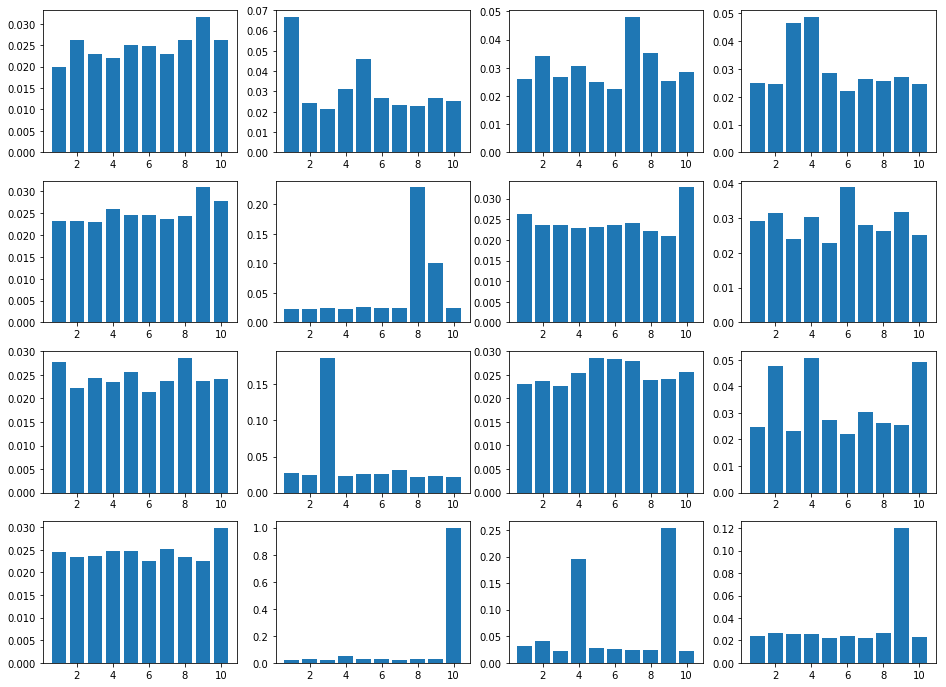

In [31]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()
for ax, indices in zip(axes, out_reset["nearest_ix"].sample(frac=1)):

    cbbl = in_frame.loc[indices].BBL
    means = [final_light_d6[c].mean() if c in final_light_d6 else final_light_d9[c].mean() for c in cbbl]
    ax.bar(range(1, 11), means)

In [119]:
ranges = []
for indices in out_reset["nearest_ix"]:
    cbbl = in_frame.loc[indices].BBL
    means = final_light[list(cbbl)].mean()
    ranges.append(means.max() - means.min())

#### Below is a histogram of log(max(mean(brightnesses)) - min(mean(brightnesses))) for brightnesses of 10nn of each out-of-frame BBL

(array([ 377., 1411., 2396., 2723., 2610., 1805.,  915., 1279.,   58.,
          47.]),
 array([-5.83206462, -5.25110869, -4.67015276, -4.08919683, -3.5082409 ,
        -2.92728497, -2.34632904, -1.76537311, -1.18441718, -0.60346125,
        -0.02250532]),
 <a list of 10 Patch objects>)

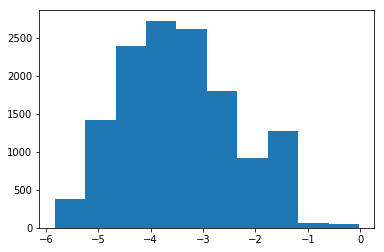

In [120]:
plt.hist(np.log(ranges))

In [ ]:
values = []
for indices in out_reset["nearest_ix"]:
    cbbl = in_frame.loc[indices].BBL
    results = final_light[list(cbbl)]
    for ix, result in results.iterrows():
        values.append((ix, result.max() - result.min()))
        
vals = np.array(values)
vals_df = pd.DataFrame({"diff": vals[:, 1].astype(np.float64)}, index=vals[:, 0].astype(np.datetime64))


Text(0.5,1,'Average diff of 10nn over time')

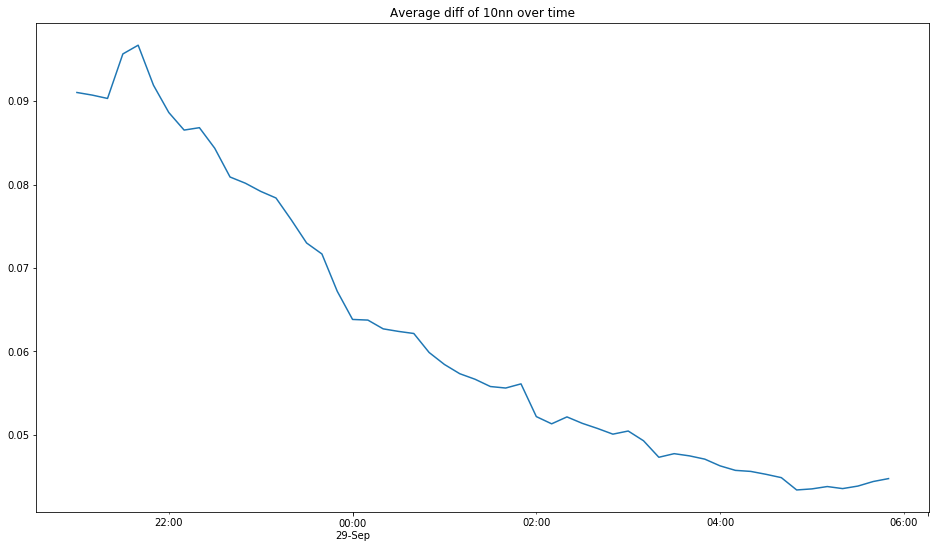

In [93]:
means = vals_df.groupby(vals_df.index)['diff'].mean()
ax = means.plot(figsize=(16, 9))
ax.set_title("Average diff of 10nn over time")

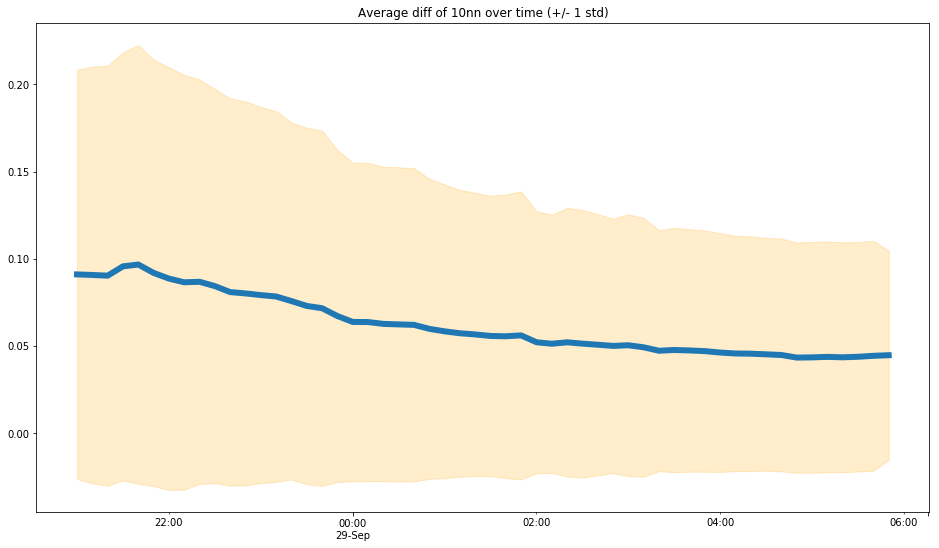

In [90]:
stds = vals_df.groupby(vals_df.index)['diff'].std()
ax = means.plot(figsize=(16, 9), linewidth=6)
ax.set_title("Average diff of 10nn over time (+/- 1 std)")
ax.fill_between(means.index, means + stds, means - stds, color='orange', alpha=.2)

Text(0.5,1,'histogram of log(max(brightnesses) - min(brightnesses)) at one time slice')

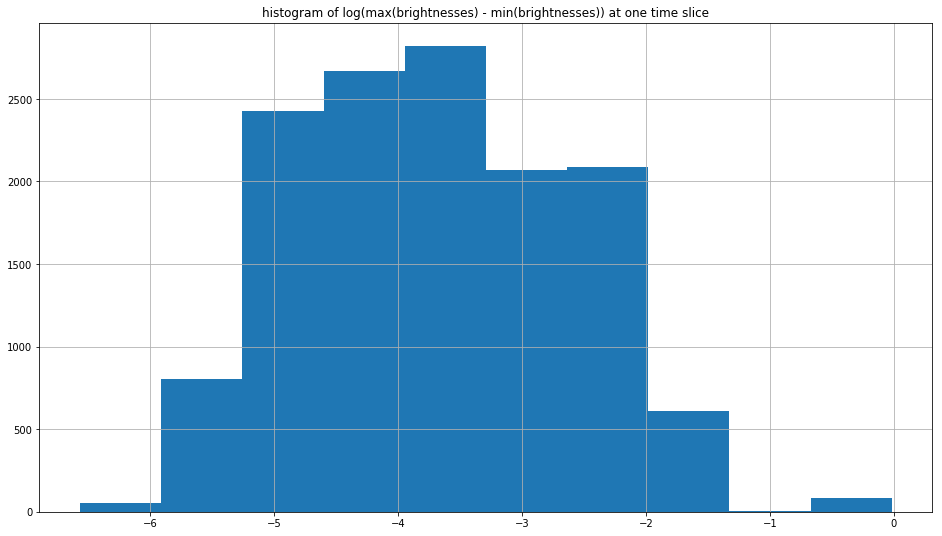

In [102]:
ax = np.log(vals_df.groupby(vals_df.index).get_group(vals_df.index[100])["diff"]).hist(figsize=(16, 9))
ax.set_title("histogram of log(max(brightnesses) - min(brightnesses)) at one time slice")

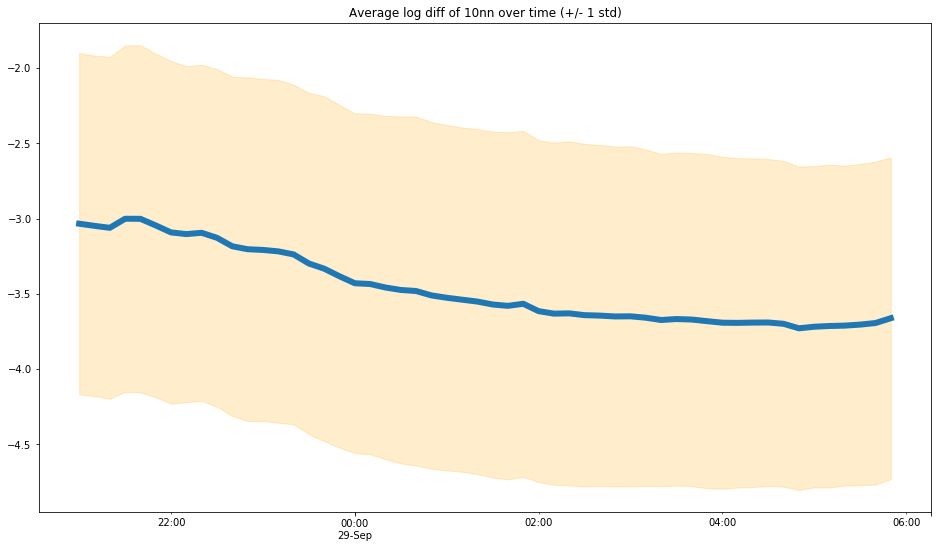

In [105]:
means = np.log(vals_df).groupby(vals_df.index)['diff'].mean()
stds = np.log(vals_df).groupby(vals_df.index)['diff'].std()
ax = means.plot(figsize=(16, 9), linewidth=6)
ax.set_title("Average log diff of 10nn over time (+/- 1 std)")
ax.fill_between(means.index, means + stds, means - stds, color='orange', alpha=.2)

Text(0.5,1,'mean BBL brightness for 2017-09-28, imputing from mean of 10nn')

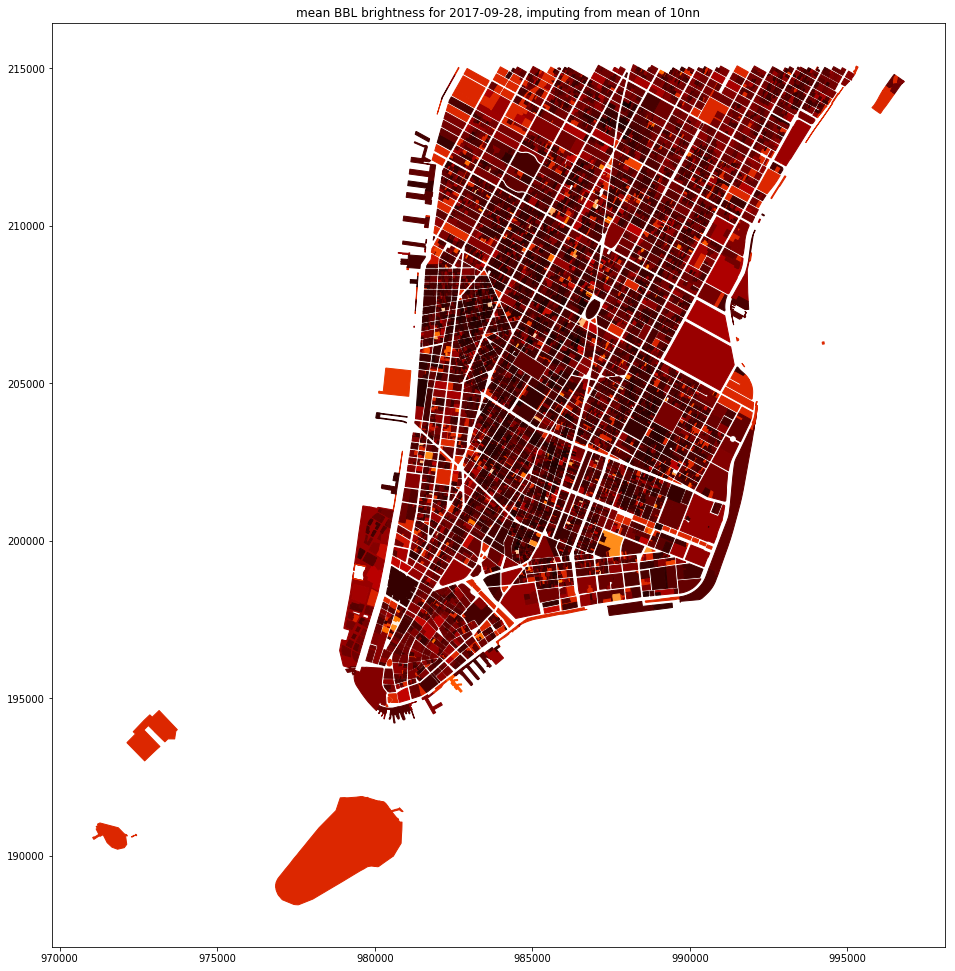

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

polys = []
colors = []
scale = np.log10(final_light.mean()).min()
for _, o_r in out_reset.iterrows():
    cbbl = in_frame.loc[o_r.nearest_ix].BBL
    c = final_light[list(cbbl)].mean().mean()
    polys.append(PolygonPatch(o_r.geometry))
    colors.append(plt.cm.gist_heat((np.log10(c) - scale)))
for _, i_r in in_frame.iterrows():
    c = final_light[i_r.BBL].mean()
    polys.append(PolygonPatch(i_r.geometry))
    colors.append(plt.cm.gist_heat((np.log10(c) - scale)))

collection = PatchCollection(polys, color=colors)
ax.add_collection(collection)
ax.autoscale_view()
ax.set_aspect(1)
ax.set_title("mean BBL brightness for 2017-09-28, imputing from mean of 10nn")

## Now, do 100

In [110]:
nearest_neighbors_100 = [np.abs(in_frame.surface_area - osa).sort_values()[:100].index for osa in out_frame.surface_area]
out_reset["nearest_ix_100"] = nearest_neighbors_100

Text(0.5,1,'mean BBL brightness for 2017-09-28, imputing from mean of 100nn')

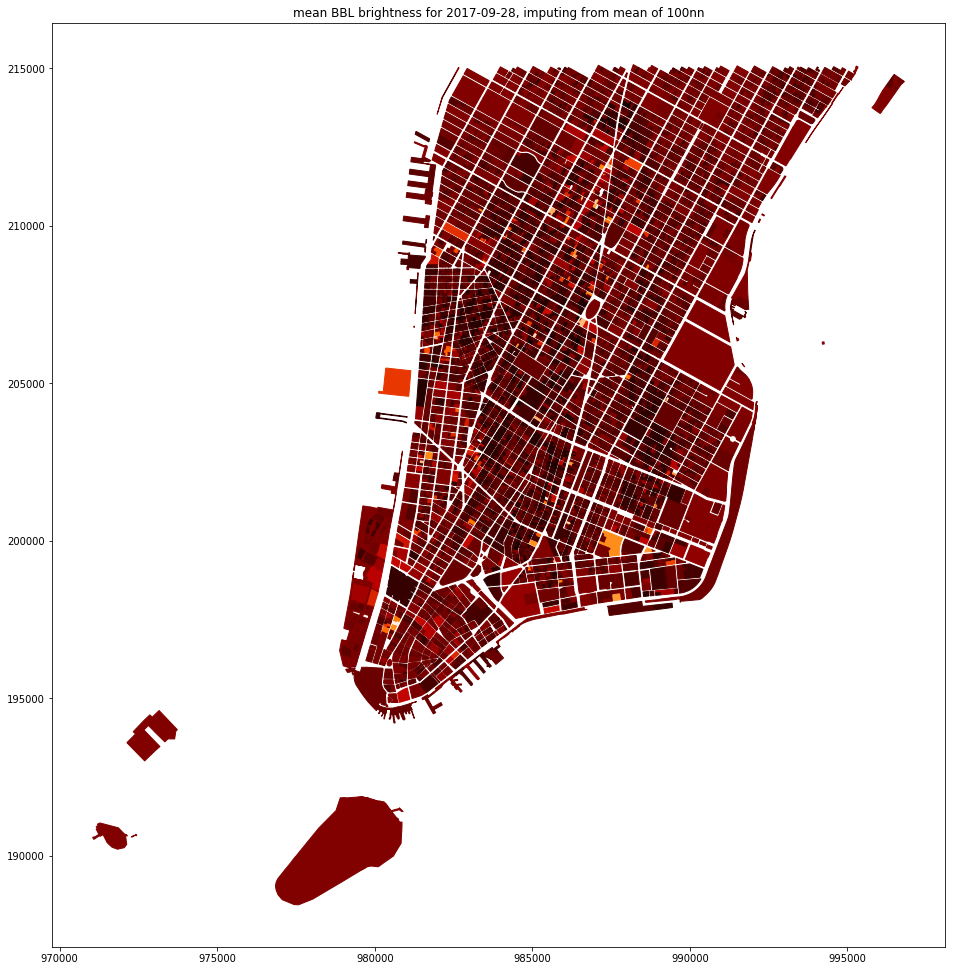

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(16, 20))

polys = []
colors = []
scale = np.log10(final_light.mean()).min()
for _, o_r in out_reset.iterrows():
    cbbl = in_frame.loc[o_r.nearest_ix_100].BBL
    c = final_light[list(cbbl)].mean().mean()
    polys.append(PolygonPatch(o_r.geometry))
    colors.append(plt.cm.gist_heat((np.log10(c) - scale)))
for _, i_r in in_frame.iterrows():
    c = final_light[i_r.BBL].mean()
    polys.append(PolygonPatch(i_r.geometry))
    colors.append(plt.cm.gist_heat((np.log10(c) - scale)))

collection = PatchCollection(polys, color=colors)
ax.add_collection(collection)
ax.autoscale_view()
ax.set_aspect(1)
ax.set_title("mean BBL brightness for 2017-09-28, imputing from mean of 100nn")

In [117]:
ranges = []
for indices in out_reset["nearest_ix_100"]:
    cbbl = in_frame.loc[indices].BBL
    means = final_light[list(cbbl)].mean()
    ranges.append(means.max() - means.min())


#### Below is a histogram of log(max(mean(brightnesses)) - min(mean(brightnesses))) for brightnesses of 100nn of each out-of-frame BBL

(array([ 821., 1177., 1837., 1428., 2381., 4698.,  153.,  307.,  480.,
         339.]),
 array([-3.44736644, -3.10442021, -2.76147398, -2.41852774, -2.07558151,
        -1.73263527, -1.38968904, -1.0467428 , -0.70379657, -0.36085034,
        -0.0179041 ]),
 <a list of 10 Patch objects>)

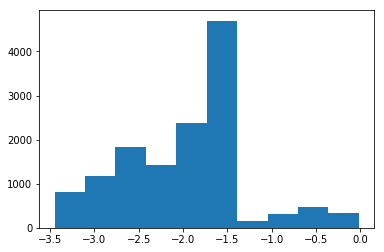

In [118]:
plt.hist(np.log(ranges))